In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import os
from tqdm import tqdm_notebook as tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
%matplotlib inline
pd.set_option('display.max_columns', 300)

In [15]:
TRAIN_PATH = "train.csv"
TEST_PATH = "test.csv"
SUB_PATH = "atmacup10__sample_submission.csv"

In [16]:
SEED = 0
N_SPLITS = 5
SHUFFLE = True
LGBM_PARAMS = {'num_leaves': 32,
               'min_data_in_leaf': 64,
               'objective': 'regression',
               'max_depth': -1,
               'learning_rate': 0.05,
               "boosting": "gbdt",
               "bagging_freq": 1,
               "bagging_fraction": 0.8,
               "bagging_seed": SEED,
               "verbosity": -1,
              'reg_alpha': 0.1,
              'reg_lambda': 0.3,
              'colsample_bytree': 0.7,
              'metric':"rmse",
              'num_threads':6,
         }

LGBM_FIT_PARAMS = {
    'num_boost_round': 10000,
    'early_stopping_rounds': 200,
    'verbose_eval': 200,
}

SAVE_TEST_SUB_PATH = "lgb_baseline.csv"

In [17]:
def train_lgbm(X_train, y_train, X_valid, y_valid, X_test, categorical_features, feature_name, fold_id,lgb_params, fit_params, loss_func, calc_importances=True):

    train = lgb.Dataset(X_train, y_train,
                        categorical_feature=categorical_features,
                        feature_name=feature_name)
    if X_valid is not None:
        valid = lgb.Dataset(X_valid, y_valid,
                            categorical_feature=categorical_features,
                            feature_name=feature_name)

    if X_valid is not None:
        model = lgb.train(
            lgb_params,
            train,
            valid_sets=[train,valid],
            **fit_params
        )
    else:
        model = lgb.train(
            lgb_params,
            train,
            **fit_params
        )

    # train score
    if X_valid is not None:
        y_pred_valid = model.predict(X_valid)
        valid_loss = loss_func(y_valid, y_pred_valid)
    else:
        y_pred_valid = None
        valid_loss = None

    #test
    if X_test is not None:
        y_pred_test = model.predict(X_test)
    else:
        y_pred_test = None

    if calc_importances:
        importances = pd.DataFrame()
        importances['feature'] = feature_name
        importances['gain'] = model.feature_importance(importance_type='gain')
        importances['split'] = model.feature_importance(importance_type='split')
        importances['fold'] = fold_id
    else:
        importances = None

    return y_pred_valid, y_pred_test, valid_loss, importances, model.best_iteration

def calc_loss(y_true, y_pred):
    return  np.sqrt(mean_squared_error(y_true, y_pred))

In [18]:
train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)
len_train = len(train)
y = np.log1p(train["likes"])

In [19]:
#使えそうな数値データと、カテゴリデータ
cols = ['principal_maker', 'principal_or_first_maker',
        'copyright_holder','acquisition_method',
       'acquisition_credit_line', 
       'dating_period', 'dating_year_early',
       'dating_year_late']
#カテゴリデータ
cat_cols = ['principal_maker', 'principal_or_first_maker','copyright_holder','acquisition_method','acquisition_credit_line']

In [20]:
#カテゴリデータにおいて、trainにあってtestにない。testにあってtrainにない。ものはnan的な？
train.loc[~train['principal_maker'].isin(test['principal_maker'].unique()),'principal_maker']

2            Tresling & Comp.
3            Bernard te Gempt
23               Jan van Gool
31        Jacob van Nieulandt
36          A. Cucumus & Cie.
                 ...         
11964              P. Bertoja
11998          Panhard Frères
12011          Franz Weisbrod
12016    David Ryckaert (III)
12025      Bartolommeo Suardi
Name: principal_maker, Length: 1336, dtype: object

In [21]:
#カテゴリデータにおいて、trainにあってtestにない。testにあってtrainにない。ものはnan的な？
for c in cat_cols:
    train.loc[~train[c].isin(test[c].unique()),c] = np.nan
    test.loc[~test[c].isin(train[c].unique()),c] = np.nan
train = pd.concat([train[cols],test[cols]]).reset_index(drop=True)

In [22]:
train.loc[~train['principal_maker'].isin(test['principal_maker'].unique()),'principal_maker']

Series([], Name: principal_maker, dtype: object)

In [23]:
#LabelEncoder(trainにtrainとtest入ってる)
for c in cat_cols:
    train[c] = train[c].astype(str)
    le = LabelEncoder()
    train[c] = le.fit_transform(train[c])

In [24]:
#trainとtest再度分割
test = train.iloc[len_train:].reset_index(drop=True)
train = train.iloc[:len_train].reset_index(drop=True)

In [25]:
kf = KFold(n_splits=N_SPLITS,random_state=SEED, shuffle=SHUFFLE)
y_oof = np.empty([len(train),])
y_test = []
features = list(train.columns)
drop_cols = []
features = [i for i in features if i not in drop_cols]
feature_importances = pd.DataFrame()
categorical_features = ["principal_maker","principal_or_first_maker"]
for fold, (train_idx, valid_idx) in enumerate(kf.split(train,y)):
    print('Fold {}'.format(fold + 1))
    x_train, y_train = train.iloc[train_idx][features], y.iloc[train_idx]
    x_val, y_val =train.iloc[valid_idx][features], y.iloc[valid_idx]

    y_pred_valid, y_pred_test, valid_loss, importances, best_iter = train_lgbm(
                x_train, y_train, x_val, y_val,test[features],
                categorical_features=categorical_features,
                feature_name=features,
                fold_id=fold,
                lgb_params=LGBM_PARAMS,
                fit_params=LGBM_FIT_PARAMS,
                loss_func=calc_loss,
                calc_importances=True
            )

    y_oof[valid_idx] = y_pred_valid
    score = calc_loss(y[valid_idx], y_pred_valid)
    y_test.append(y_pred_test)
    feature_importances = pd.concat([feature_importances, importances], axis=0, sort=False)

score = calc_loss(y, y_oof)
print(score)

Fold 1
Training until validation scores don't improve for 200 rounds


/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[200]	training's rmse: 1.16981	valid_1's rmse: 1.27985
[400]	training's rmse: 1.11508	valid_1's rmse: 1.27066
[600]	training's rmse: 1.08031	valid_1's rmse: 1.26899
[800]	training's rmse: 1.05506	valid_1's rmse: 1.26827
[1000]	training's rmse: 1.0341	valid_1's rmse: 1.26911
Early stopping, best iteration is:
[862]	training's rmse: 1.04822	valid_1's rmse: 1.2678
Fold 2
Training until validation scores don't improve for 200 rounds


/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[200]	training's rmse: 1.17769	valid_1's rmse: 1.25464
[400]	training's rmse: 1.12491	valid_1's rmse: 1.23637
[600]	training's rmse: 1.09015	valid_1's rmse: 1.22929
[800]	training's rmse: 1.06426	valid_1's rmse: 1.22677
[1000]	training's rmse: 1.04302	valid_1's rmse: 1.22573
[1200]	training's rmse: 1.02574	valid_1's rmse: 1.22664
Early stopping, best iteration is:
[1149]	training's rmse: 1.02984	valid_1's rmse: 1.22478
Fold 3
Training until validation scores don't improve for 200 rounds


/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[200]	training's rmse: 1.16875	valid_1's rmse: 1.31153
[400]	training's rmse: 1.11372	valid_1's rmse: 1.29784
[600]	training's rmse: 1.07835	valid_1's rmse: 1.2934
[800]	training's rmse: 1.05182	valid_1's rmse: 1.29231
Early stopping, best iteration is:
[693]	training's rmse: 1.06506	valid_1's rmse: 1.29147
Fold 4
Training until validation scores don't improve for 200 rounds


/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[200]	training's rmse: 1.18134	valid_1's rmse: 1.25549
[400]	training's rmse: 1.12711	valid_1's rmse: 1.24433
[600]	training's rmse: 1.09314	valid_1's rmse: 1.23682
[800]	training's rmse: 1.06792	valid_1's rmse: 1.2325
[1000]	training's rmse: 1.04711	valid_1's rmse: 1.2317
[1200]	training's rmse: 1.02968	valid_1's rmse: 1.23094
[1400]	training's rmse: 1.01488	valid_1's rmse: 1.23165
Early stopping, best iteration is:
[1306]	training's rmse: 1.02167	valid_1's rmse: 1.2301
Fold 5
Training until validation scores don't improve for 200 rounds


/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[200]	training's rmse: 1.1788	valid_1's rmse: 1.26279
[400]	training's rmse: 1.12356	valid_1's rmse: 1.24959
[600]	training's rmse: 1.0888	valid_1's rmse: 1.25017
[800]	training's rmse: 1.06217	valid_1's rmse: 1.25013
Early stopping, best iteration is:
[724]	training's rmse: 1.07148	valid_1's rmse: 1.24853
1.2527785580029036


In [26]:
y_test_sub =  np.mean(y_test,axis=0)
y_test_sub = np.expm1(y_test_sub)
sub = pd.read_csv(SUB_PATH)
sub["likes"] = y_test_sub
sub.loc[sub.likes <= 0,"likes"] = 0
sub.to_csv(SAVE_TEST_SUB_PATH,index=False)

In [201]:
feature_importances.query('fold == 0').sort_values('gain',ascending=False)


,feature,gain,split,fold
6,dating_year_early,40774.598786,8081,0
7,dating_year_late,39068.425750,8247,0
3,acquisition_method,38901.493166,1947,0
0,principal_maker,33223.926020,2429,0
1,principal_or_first_maker,25979.397087,1754,0
4,acquisition_credit_line,22325.852270,3710,0
5,dating_period,2306.283311,491,0
2,copyright_holder,194.111334,63,0


In [202]:
feature_importances.query('fold == 1').sort_values('gain',ascending=False)

,feature,gain,split,fold
6,dating_year_early,43532.317859,10721,1
7,dating_year_late,43445.505784,11264,1
0,principal_maker,39770.158656,3250,1
3,acquisition_method,37920.978873,2518,1
1,principal_or_first_maker,26845.927680,2292,1
4,acquisition_credit_line,25319.982651,4850,1
5,dating_period,2030.067552,609,1
2,copyright_holder,259.546758,115,1


In [203]:
feature_importances.query('fold == 2').sort_values('gain',ascending=False)

,feature,gain,split,fold
7,dating_year_late,36920.165121,6614,2
3,acquisition_method,36231.686252,1502,2
6,dating_year_early,36083.248007,6391,2
0,principal_maker,32224.456346,1941,2
1,principal_or_first_maker,24245.080700,1400,2
4,acquisition_credit_line,21205.786463,3226,2
5,dating_period,1604.447027,348,2
2,copyright_holder,295.379847,61,2


In [204]:
feature_importances.query('fold == 3').sort_values('gain',ascending=False)

,feature,gain,split,fold
7,dating_year_late,46868.253318,12802,3
6,dating_year_early,46337.056075,12523,3
0,principal_maker,39795.071858,3690,3
3,acquisition_method,38410.736108,2909,3
1,principal_or_first_maker,27427.054100,2582,3
4,acquisition_credit_line,24575.474489,5222,3
5,dating_period,1806.289246,635,3
2,copyright_holder,283.161792,123,3


In [205]:
feature_importances.query('fold == 4').sort_values('gain',ascending=False)

,feature,gain,split,fold
7,dating_year_late,38352.088600,6987,4
3,acquisition_method,36346.734240,1624,4
6,dating_year_early,35172.149758,6659,4
0,principal_maker,34814.720287,1944,4
1,principal_or_first_maker,23932.430841,1513,4
4,acquisition_credit_line,23244.209306,3270,4
5,dating_period,1832.012379,385,4
2,copyright_holder,235.670375,62,4


In [171]:
# 特徴量重要度を棒グラフでプロットする関数 
def plot_feature_importance(df): 
    n_features = len(df)                              # 特徴量数(説明変数の個数) 
    df_plot = df.sort_values('gain')            # df_importanceをプロット用に特徴量重要度を昇順ソート 
    f_importance_plot = df_plot['gain'].values  # 特徴量重要度の取得 
    plt.barh(range(n_features), f_importance_plot, align='center') 
    cols_plot = df_plot['feature'].values             # 特徴量の取得 
    plt.rcParams["font.size"] = 6
    plt.yticks(np.arange(n_features), cols_plot)      # x軸,y軸の値の設定
    plt.xlabel('Feature importance')                  # x軸のタイトル
    plt.ylabel('Feature')  # y軸のタイトル
    plt.tight_layout()
    figsize=(12, 8)
plt.show()

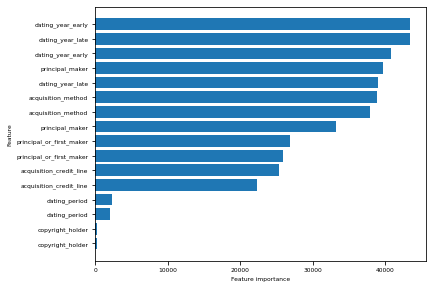

In [185]:
# 特徴量重要度の可視化
n_display = 16 # 上位10個に制限
plot_feature_importance(df.iloc[:n_display,:])

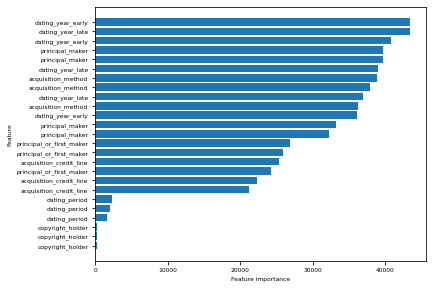

In [186]:
# 特徴量重要度の可視化
n_display = 25 # 上位10個に制限
plot_feature_importance(df.iloc[:n_display,:])

In [183]:
# 可視化（modelはlightgbmで学習させたモデル）
lgb.plot_importance(model, figsize=(12, 8))
plt.show()

NameError: name 'model' is not defined